# 3D detailed analysis

This tutorial does a 3D map based analsis on the galactic center, using simulated observations from the CTA-1DC. We will use the high level interface for the data reduction, and then do a detailed modelling. This will be done in two different ways:

- stacking all the maps together and fitting the stacked maps
- handling all the observations separately and doing a joint fitting on all the maps

In [1]:
import gammapy
gammapy.__version__

'0.19'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import RectangleSkyRegion, CircleSkyRegion
from regions import CircleSkyRegion
from scipy.stats import norm
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.estimators import ExcessMapEstimator
from gammapy.datasets import MapDataset
from gammapy.catalog import SourceCatalogHGPS, SourceCatalog2HWC

## Analysis configuration

In this section we select observations and define the analysis geometries, irrespective of  joint/stacked analysis. For configuration of the analysis, we will programmatically build a config file from scratch.

In [3]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion:

In [4]:
# Selecting the observations
config.observations.datastore = "/home/lucagiunti/gammapy-datasets/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

In [5]:
# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

In [6]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: /home/lucagiunti/gammapy-datasets/cta-1dc/index/gps
        obs_ids: [110380, 111140, 111159]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 0.0 deg, lat: 0.0 deg}
                binsize: 0.02 deg
                width: {width: 10.0 deg, height: 8.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.08 TeV, max: 12.0 TeV, nbins: 14}
        map_selection: [counts, exposure, background, psf, edisp]
       

## Configuration for stacked and joint analysis

This is done just by specfiying the flag on `config.datasets.stack`. Since the internal machinery will work differently for the two cases, we will write it as two config files and save it to disc in YAML format for future reference. 

In [7]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

In [8]:
# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

## Stacked analysis

### Data reduction

We first show the steps for the stacked analysis and then repeat the same for the joint analysis later


In [9]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

In [10]:
analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [11]:
%%time
# select observations:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
No HDU found matching: OBS_ID = 110380, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111140, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111159, HDU_TYPE = rad_max, HDU_CLASS = None
Number of selected observations: 3
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No default thresholds defined for obs 110380
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No default thresholds defined for obs 111140
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
No default thresholds defined for obs 111159


CPU times: user 13.2 s, sys: 1.97 s, total: 15.2 s
Wall time: 15.2 s


We have one final dataset, which you can print and explore

In [12]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 121241 
  Total background counts         : 108043.52
  Total excess counts             : 13197.48

  Predicted counts                : 108043.52
  Predicted background counts     : 108043.52
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1411180 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [13]:
# To plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [14]:
# And the background map
dataset_stacked.background.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

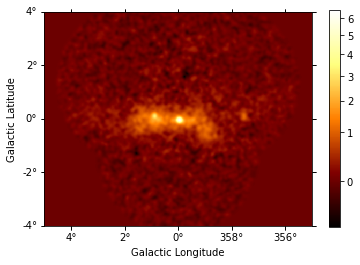

In [15]:
# You can also get an excess image with a few lines of code:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

# Estimate flux assuming the default PL

In [16]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.6, 10] * u.TeV,
    spectral_model=PowerLawSpectralModel()
)

result = estimator.run(dataset_stacked)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

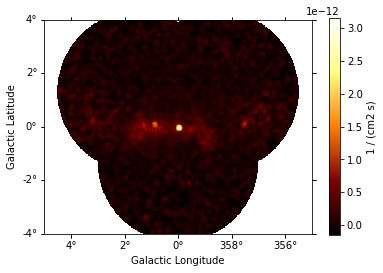

In [17]:
result["flux"].plot(add_cbar=True)

# Change the norm of the default PL

In [18]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.6, 10] * u.TeV,
    spectral_model=PowerLawSpectralModel(amplitude="1 TeV-1 m-2 s-1")
)

result = estimator.run(dataset_stacked)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

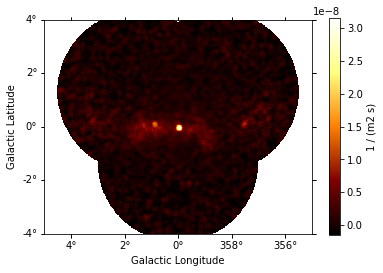

In [19]:
result["flux"].plot(add_cbar=True)